In [140]:
import numpy as np
import random
import matplotlib.pyplot as plt
np.random.seed(420000)



class material:
    def __init__(self,name:str,sigma_a:float,sigma_s:float,sigma_f:float,nu:float):
        
        self.name=name
        self.sigma_a=sigma_a
        self.sigma_s=sigma_s
        self.sigma_f=sigma_f
        self.nu=nu

        self.sigma_t=self.sigma_a+self.sigma_f+sigma_s


class source:
    def __init__(self,type:str,r:float):
        self.r=r     



def sample_initial_neutrons(number_of_neutrons,source:object):
    """ 
    will accept the number of neutrons and send their sampled x,y position. 
    plt.figure(figsize=(10,10))
    """
    x=np.random.uniform(-source.r,source.r,size=number_of_neutrons)/np.exp(np.random.uniform(0,np.pi*2,size=number_of_neutrons))
    #y=np.random.uniform(-source.r,source.r,size=number_of_neutrons)/np.sin(np.random.uniform(0,np.pi*2,size=number_of_neutrons))-2
    y=x

    return x,y 






In [141]:


X_left=-5
X_right=5

Y_up=5
Y_down=-5

Nx=100
Ny=Nx

dx=(X_right-X_left)/Nx
dy=(Y_up-Y_down)/Ny

X = np.linspace(dx*0.5, (X_right-X_left) - 0.5*dx,Nx)
Y = np.linspace(dx*0.5, (Y_up-Y_down) - 0.5*dx,Ny)



In [142]:
uo2=material(name='fuel',sigma_a=0.2,sigma_f=.03,sigma_s=3,nu=2.5)
h20=material(name='coolant',sigma_a=.05,sigma_f=0,sigma_s=0.7,nu=0)

source=source(type='neutron',r=2)

fuel_rad=5

def find_mat(pos):

    x=pos[0]
    y=pos[1]
    
    if x**2+y**2<=fuel_rad:
        return uo2
    elif(x**2+y**2>fuel_rad) and abs(x)<=X_right and abs (y)<=Y_up :
        return h20
    else:
        return None
    
def find_surface_intersection_point(pos,pos_new):

    a=pos[0]
    b=pos[1]
    a_new=pos_new[0]
    b_new=pos_new[1]

    tol=1e-7

    for i in range (100):
        x=(a+a_new)/2
        y=(b+b_new)/2

        if abs(x**2+y**2-fuel_rad)<tol:
            break
        elif (x**2+y**2-fuel_rad)>0:
            a_new=x
            b_new=y
        elif (x**2+y**2-fuel_rad)<0:
            a=x
            b=y
    return x,y

In [143]:
active_batch=10
inactive_batch=0
no_of_gen_per_batch=1
number_of_neutrons=1000
N=number_of_neutrons

total_batch=active_batch+inactive_batch
collision_counter=np.zeros(((active_batch+inactive_batch),no_of_gen_per_batch,Nx,Ny))
scalar_flux=np.zeros(((active_batch+inactive_batch),no_of_gen_per_batch,Nx,Ny))
weights=np.ones(number_of_neutrons)

In [144]:

x,y=sample_initial_neutrons(number_of_neutrons=number_of_neutrons,source=source)

(-10.0, 10.0)

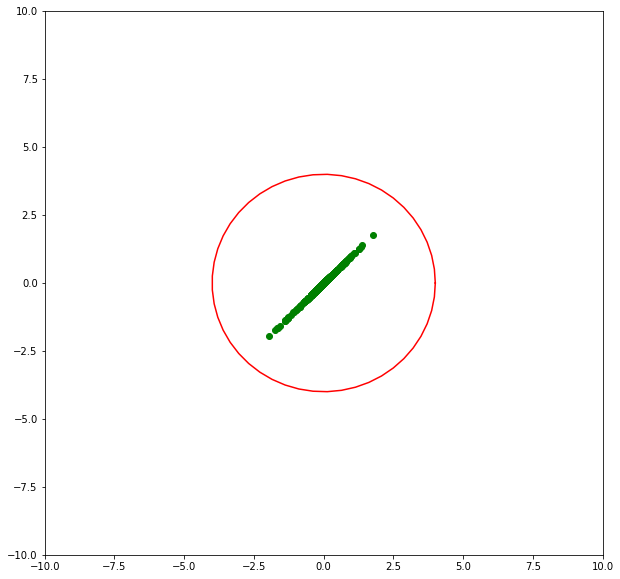

In [145]:
plt.figure(figsize=(10,10))
plt.scatter(x,y,color='g')
plt.plot(4*np.cos(np.linspace(0,np.pi*2)),4*np.sin(np.linspace(0,np.pi*2)),color='red')
plt.xlim(-10,10)
plt.ylim(-10,10)

In [146]:

fission_sites_x=np.array([])
fission_sites_y=np.array([])

k=np.zeros(active_batch+inactive_batch)



In [147]:
for batch in range (active_batch+inactive_batch):
    
    number_of_neutrons=N
    weights=np.ones(number_of_neutrons)
    scalar_flux = np.zeros((Nx,Ny))


    for gen in range(no_of_gen_per_batch):
        
        weights_old=weights.copy()
        next_gen_neutron=0

        for n in range(number_of_neutrons):
 
            mu=np.random.rand()*2-1
            eta=np.sqrt(1-mu**2)
            initail_dir=np.array([mu,eta])

            weight=weights[n]
            
            alive=True
            pos=np.array([x[n],y[n]])


            
            while alive: 

                ''' sample distance first'''
                material=find_mat(pos)
                rand_num=np.random.rand()               
                l=-np.log(rand_num)/material.sigma_t

                """ check it the from that position the particle will cross any boundray?"""
                if find_mat(pos)!=find_mat(pos+l*initail_dir):

                    '''calculating the boundary crossing position'''
                    x_,y_=find_surface_intersection_point(pos=pos,pos_new=(pos+l*initail_dir))
                    l=np.sqrt((x_-pos[0])**2+(y_-pos[1])**2)
                    
                
                #sample the angualar direction as well
                

                if find_mat(pos)==None: 
                    alive=False
                else: 
                    '''
                      now we sample the direction 
                    '''
                    reaction_type=np.random.choice(['scattering','capture','fission'],p=[material.sigma_s/material.sigma_t,material.sigma_a/material.sigma_t,material.sigma_f/material.sigma_t])
                    
                    if reaction_type=='scattering':
                        '''
                            change particle direction by sampling new mu and eta for new direction 
                        '''
                        mu=np.random.rand()*2-1
                        eta=np.sqrt(1-mu**2)
                        
                        if np.random.rand()<=0.5:
                            eta=-eta

                        pos=pos+l*initail_dir
                        initail_dir=np.array([mu,eta])
                        
                        #weight=weight*material.sigma_s
                        

                        #scalar_flux[x_cell_index][y_cell_index]=scalar_flux[x_cell_index][y_cell_index]+weight
                        if pos[0]>0 and abs(pos[0])>dx:
                            x_cell_index=int( Nx/2+int(abs(pos[0]/dx)))
                        elif pos[0]<0 and abs (pos[0])>dx :
                            x_cell_index=int( Nx/2-int(abs(pos[0]/dx)))
                        elif abs(pos[0])<dx:
                            x_cell_index=int(Nx/2)

                        if pos[1]>0 and abs(pos[1])>dy:
                            y_cell_index=int( Ny/2+int(abs(pos[1]/dy)))
                        elif pos[1]<0 and abs(pos[1])>dy:
                            y_cell_index=int( Ny/2-int(abs(pos[1]/dy)))
                        elif abs(pos[1])<dy:
                            y_cell_index=int(Ny/2)
                            
                        collision_counter[batch][gen][x_cell_index][y_cell_index]+=1/(dx*dy*material.sigma_t)

                    elif reaction_type=='capture':
                        
                        weight=weight*material.sigma_a

                        
                        if pos[0]>0 and abs(pos[0])>dx:
                            x_cell_index=int( Nx/2+int(abs(pos[0]/dx)))
                        elif pos[0]<0 and abs (pos[0])>dx :
                            x_cell_index=int( Nx/2-int(abs(pos[0]/dx)))
                        elif abs(pos[0])<dx:
                            x_cell_index=int(Nx/2)

                        if pos[1]>0 and abs(pos[1])>dy:
                            y_cell_index=int( Ny/2+int(abs(pos[1]/dy)))
                        elif pos[1]<0 and abs(pos[1])>dy:
                            y_cell_index=int( Ny/2-int(abs(pos[1]/dy)))
                        elif abs(pos[1])<dy:
                            y_cell_index=int(Ny/2)

                        collision_counter[batch][gen][x_cell_index][y_cell_index]+=1/(dx*dy*material.sigma_t)

                        alive=False
                        
                    else: 
                        ''' as there are only three choice the other one will be fission 

                            1. adjust particle weight and kill the particle
                            2. keep the record of the fissoion sites 
                            3. keepfission_sites_y the record of the fission site's weights 

                        '''                    
                        rand_num=np.random.rand()

                        if rand_num>(material.nu-int(material.nu)):
                            new_neutrons=int(material.nu)+1
                        else:
                            new_neutrons=int(material.nu)
                        
                        
                        #x_cell_index=int(abs(pos[0]/dx))
                        #y_cell_index=int(abs(pos[1]/dy))  
                        #something is wrong with the indexing here.

                        if pos[0]>0 and abs(pos[0])>dx:
                            x_cell_index=int( Nx/2+int(abs(pos[0]/dx)))
                        elif pos[0]<0 and abs (pos[0])>dx :
                            x_cell_index=int( Nx/2-int(abs(pos[0]/dx)))
                        elif abs(pos[0])<dx:
                            x_cell_index=int(Nx/2)
                            

                        if pos[1]>0 and abs(pos[1])>dy:
                            y_cell_index=int( Ny/2+int(abs(pos[1]/dy)))
                        elif pos[1]<0 and abs(pos[1])>dy:
                            y_cell_index=int( Ny/2-int(abs(pos[1]/dy)))
                        elif  abs(pos[1])<dy:
                            y_cell_index=int(Ny/2)

                        collision_counter[batch][gen][x_cell_index][y_cell_index]+=1/(dx*dy*material.sigma_t)

                        next_gen_neutron=next_gen_neutron+new_neutrons
                      
                        for i in range (new_neutrons):
                            fission_sites_y=np.append(fission_sites_y,pos[1])
                            fission_sites_x=np.append(fission_sites_x,pos[0])

        #plt.figure(figsize=(10,10))
        #plt.scatter(fission_sites_x,fission_sites_y)
        for i in range(number_of_neutrons): 
            x[i]=random.choice(fission_sites_x)
            y[i]=random.choice(fission_sites_y)
        record=[fission_sites_x,fission_sites_y]
        
        fission_sites_x=np.array([])
        fission_sites_y=np.array([])
    
    k[batch]=(next_gen_neutron/number_of_neutrons)


    collision_counter[batch][gen][:][:]=collision_counter[batch][gen][:][:]/number_of_neutrons

    if batch> inactive_batch:
        print('%.6f' % (next_gen_neutron/number_of_neutrons), ' ','%.6f' % np.mean(k[inactive_batch:batch]),"+/-",'%.6f' % np.std(k[inactive_batch:batch]))
    else:
        print('%.6f' % (next_gen_neutron/number_of_neutrons))
    number_of_neutrons=next_gen_neutron
    
    scalar_flux=np.zeros_like(scalar_flux)


0.322000
0.318000   0.322000 +/- 0.000000
0.280000   0.320000 +/- 0.002000
0.243000   0.306667 +/- 0.018927
0.300000   0.290750 +/- 0.032073
0.272000   0.292600 +/- 0.028925
0.263000   0.289167 +/- 0.027498
0.301000   0.285429 +/- 0.027055
0.249000   0.287375 +/- 0.025826
0.261000   0.283111 +/- 0.027172


In [148]:
print('%.6f' % np.mean(k[inactive_batch:batch]),"+/-",'%.6f' % np.std(k[inactive_batch:batch]))


0.283111 +/- 0.027172


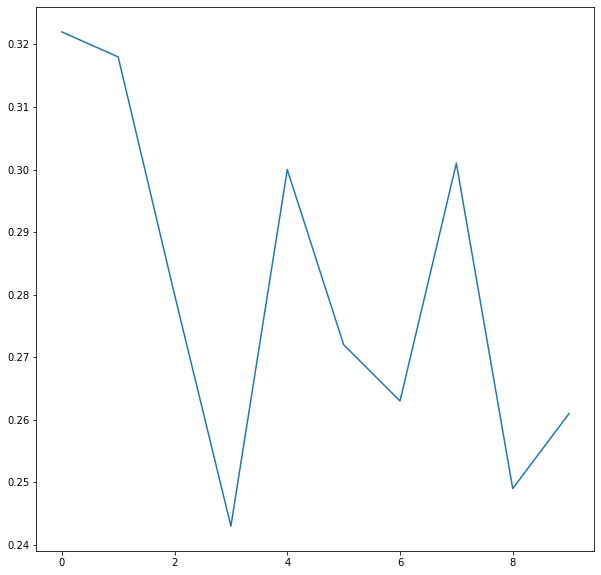

In [149]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(k)

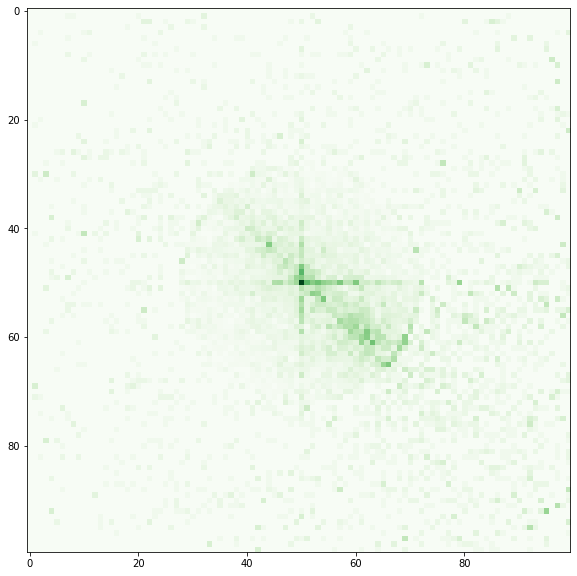

In [150]:
import matplotlib.cm as cm
plt.figure(figsize=(10,10))
plt.imshow(collision_counter[-1][0][:][:],cmap=cm.Greens)

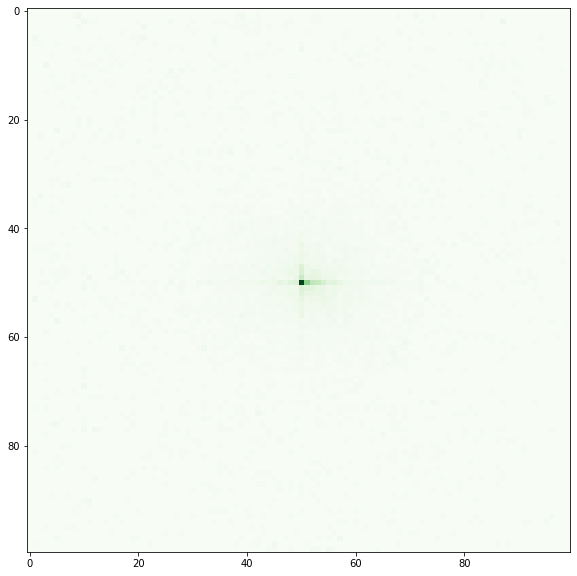

In [151]:
import matplotlib.cm as cm
plt.figure(figsize=(10,10))
plt.imshow(collision_counter[0][0][:][:],cmap=cm.Greens)

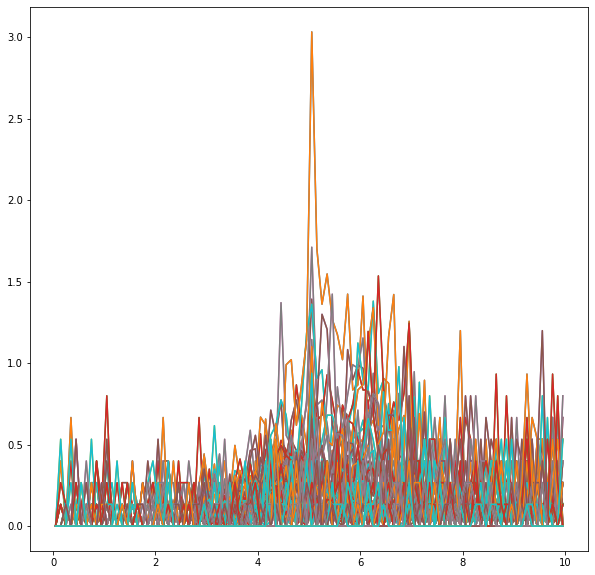

In [201]:
plt.figure(figsize=(10,10))
flux=np.zeros_like(collision_counter[-1][0][:][:])

for i in range (Nx):
    plt.plot(X,(collision_counter[-1][0][i][:]))
    plt.plot(X,(collision_counter[-1][0][:][i]))